# Develop negative log-likelihood with scaled inputs

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz

## Simulate measurements

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
delta = np.zeros(n)
alpha = np.zeros(m - 1)
eta = np.zeros(m - 1)

logv = np.log(sigma**2)
scale_logv = 1e-1 * np.ones(3)
scale_delta = 1e-1 * thz.noiseamp(sigma, mu, ts)
scale_alpha = 1e-1 * np.ones(m - 1)
scale_eta = 1e-2 * np.ones(m - 1)
scale_v = 1.0e-2

## Check gradient

In [3]:
_, grad_delta_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=np.ones(n),
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=1.0,
)

_, grad_delta_tdnll_scaled = thz.tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v) / scale_logv,
    delta / scale_delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=scale_logv,
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_delta_nd = nd.Gradient(
    lambda _delta: thz.tdnll_scaled(
        x,
        np.log(np.exp(logv) / scale_v),
        _delta,
        alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=np.ones(n),
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0],
    step=1e-6,
)(delta)

np.stack(
    (
        grad_delta_tdnll,
        grad_delta_tdnll_scaled / scale_v / scale_delta,
        grad_delta_nd / scale_v,
    )
).T

array([[-1.78499301e+06, -1.78499301e+06, -1.78499136e+06],
       [ 3.34408331e+05,  3.34408331e+05,  3.34407730e+05],
       [-3.18976037e+06, -3.18976037e+06, -3.18975647e+06],
       [ 6.25507562e+03,  6.25507562e+03,  6.25536200e+03],
       [ 2.73178830e+06,  2.73178830e+06,  2.73178513e+06],
       [-7.20470280e+05, -7.20470280e+05, -7.20468844e+05],
       [-4.21790087e+06, -4.21790087e+06, -4.21789518e+06],
       [-2.82140739e+06, -2.82140739e+06, -2.82140365e+06],
       [ 2.53462945e+06,  2.53462945e+06,  2.53462625e+06],
       [ 4.91455018e+06,  4.91455018e+06,  4.91454464e+06],
       [ 1.68262230e+06,  1.68262230e+06,  1.68262022e+06],
       [ 5.52573815e+04,  5.52573815e+04,  5.52574262e+04],
       [ 8.62734944e+06,  8.62734944e+06,  8.62734033e+06],
       [ 1.29048234e+06,  1.29048234e+06,  1.29048127e+06],
       [ 5.01868231e+06,  5.01868231e+06,  5.01867727e+06],
       [ 2.79090884e+06,  2.79090884e+06,  2.79090620e+06],
       [ 1.27722077e+06,  1.27722077e+06

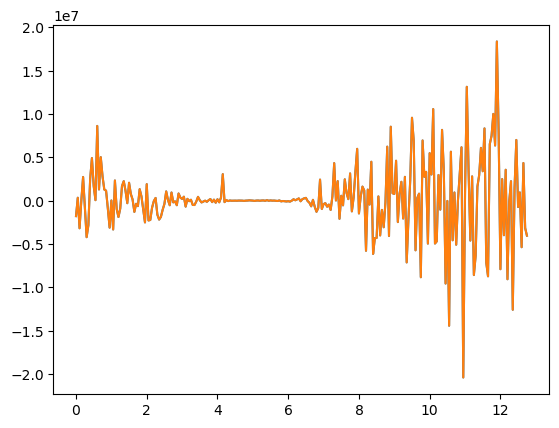

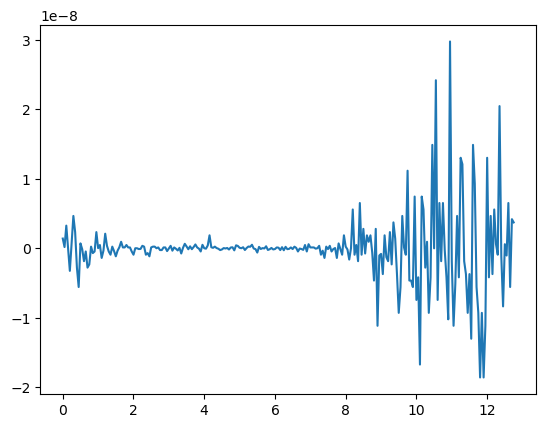

In [4]:
plt.plot(t, grad_delta_tdnll)
plt.plot(t, grad_delta_tdnll_scaled / scale_v / scale_delta)
plt.show()
plt.plot(t, grad_delta_tdnll - grad_delta_tdnll_scaled / scale_v / scale_delta)
plt.show()

In [5]:
val, grad_logv_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=1.0,
)

val_scaled_v, grad_logv_tdnll_scaled_v = thz.tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v),
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

val_scaled, grad_logv_tdnll_scaled = thz.tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v) / scale_logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=scale_logv,
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_logv_nd = nd.Gradient(
    lambda _logv: thz.tdnll_scaled(
        x,
        np.log(np.exp(_logv) / scale_v) / scale_logv,
        delta,
        alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=scale_logv,
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(logv)

print(f"{val =}")
print(f"{val_scaled_v / scale_v =}")
print(f"{val_scaled / scale_v =}")
np.stack(
    (
        grad_logv_tdnll,
        grad_logv_tdnll_scaled_v,
        grad_logv_tdnll_scaled / scale_logv,
        grad_logv_nd,
    )
).T

val =-138346.28961693967
val_scaled_v / scale_v =-138346.28961693964
val_scaled / scale_v =-138346.28961693964


array([[-2257.71900912,   -22.57719009,   -22.57719009,   -22.57719009],
       [-1623.07622749,   -16.23076227,   -16.23076227,   -16.23076227],
       [  572.86859935,     5.72868599,     5.72868599,     5.72868599]])

In [6]:
_, grad_alpha_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=False,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_alpha_nd = nd.Gradient(
    lambda _alpha: thz.tdnll_scaled(
        x,
        logv,
        delta,
        _alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(alpha)

np.stack((grad_alpha_tdnll, grad_alpha_nd)).T

array([[  467.01158574,   467.01158568],
       [  278.42731279,   278.42731278],
       [ -143.90149591,  -143.90149591],
       [  383.17022427,   383.1702243 ],
       [  812.60105051,   812.60105052],
       [   46.68069103,    46.68069102],
       [ -383.30104778,  -383.30104786],
       [  468.54204447,   468.54204447],
       [  -21.19555539,   -21.19555539],
       [  517.71550562,   517.71550563],
       [  151.16860301,   151.16860306],
       [ 1383.88389377,  1383.88389377],
       [ 1389.09347412,  1389.09347412],
       [ -474.72030302,  -474.72030309],
       [ -388.86313723,  -388.86313723],
       [  259.04357763,   259.04357765],
       [ -419.42907392,  -419.42907393],
       [ 1520.36560752,  1520.36560751],
       [  266.61271532,   266.61271532],
       [  668.87225135,   668.87225136],
       [ 1194.01033756,  1194.01033765],
       [   58.20480419,    58.20480421],
       [  507.4238035 ,   507.42380342],
       [ 1499.74299671,  1499.74299671],
       [   46.96

In [7]:
_, grad_eta_tdnll = thz.tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=False,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_eta_nd = nd.Gradient(
    lambda _eta: thz.tdnll_scaled(
        x,
        logv,
        delta,
        alpha,
        _eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(eta)

np.stack((grad_eta_tdnll, grad_eta_nd)).T

array([[  -821.62711904,   -821.62711885],
       [ -6909.80114218,  -6909.80114179],
       [ -4732.65295074,  -4732.65295018],
       [ -5370.01700225,  -5370.01700162],
       [  2851.13649241,   2851.13649253],
       [  3065.81936736,   3065.81936786],
       [ -2652.54143468,  -2652.54143315],
       [   256.48333858,    256.48333904],
       [ -5335.48992207,  -5335.48992163],
       [  3648.79227772,   3648.79227806],
       [ -8594.0315627 ,  -8594.03156205],
       [-15582.26038923, -15582.260389  ],
       [ -1272.33578444,  -1272.33578423],
       [ -4148.38535346,  -4148.38535284],
       [ -2816.9811895 ,  -2816.98118898],
       [ -9790.713087  ,  -9790.71308671],
       [ 10749.3283511 ,  10749.32835169],
       [-12694.12357316, -12694.12357291],
       [  1323.65415994,   1323.65416125],
       [  -513.93205872,   -513.93205856],
       [ -5320.63147152,  -5320.6314711 ],
       [  5567.32227213,   5567.32227273],
       [-11661.01631834, -11661.01631713],
       [  -

## Estimate noise parameters with revised NLL

In [8]:
result = thz.tdnoisefit(x.T, v0=sigma**2, ts=ts, fix_a=False, fix_eta=False)

In [9]:
print(result[2]["message"])

Optimization terminated successfully.


In [10]:
var_out = result[0]["var"] * m / (m - 1)
var_err = result[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 9.99e-11 ± 1.284e-12
Input: 0.0001	 Output: 9.696e-05 ± 2.283e-06
Input:  1e-06	 Output: 8.927e-07 ± 4.858e-08


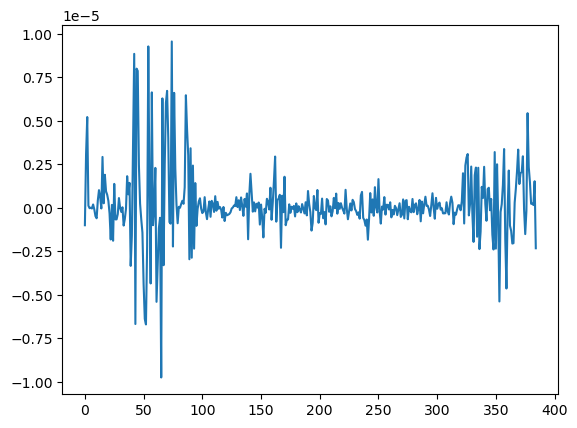

In [11]:
plt.plot(result[2]["grad_scaled"])
plt.show()

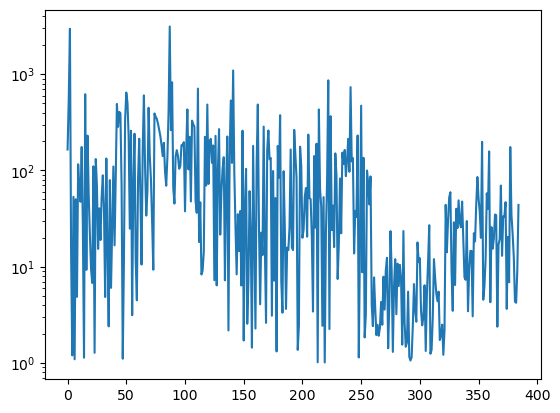

In [12]:
plt.semilogy(np.diag(result[2]["hess_inv_scaled"]))
plt.show()

In [13]:
np.diag(result[2]["hess_inv_scaled"][:3, :3])

array([ 165.08587599,  554.6795827 , 2961.39163476])

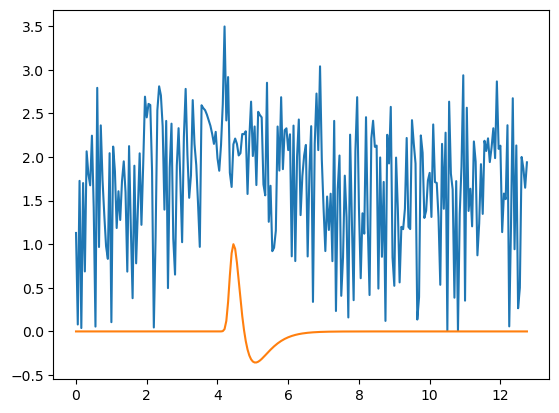

In [14]:
plt.plot(t, np.log10(np.diag(result[2]["hess_inv_scaled"])[3 : 3 + n]))
plt.plot(t, mu)
plt.show()

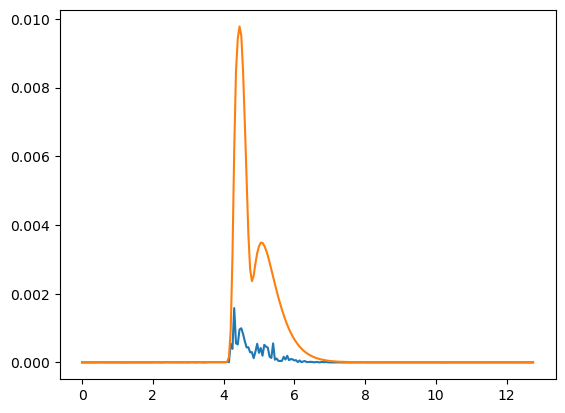

In [15]:
plt.plot(t, result[2]["err"]["delta"] * np.sqrt(m))
plt.plot(t, thz.noiseamp(np.sqrt(result[0]["var"]), result[0]["mu"], ts))
plt.show()

## Repeat fit with amplitudes and delays fixed

In [16]:
result = thz.tdnoisefit(x.T, v0=sigma**2, ts=ts, fix_a=True, fix_eta=True)
print(result[2]["message"])

Optimization terminated successfully.


In [17]:
var_out = result[0]["var"] * m / (m - 1)
var_err = result[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output:  1e-10 ± 1.228e-12
Input: 0.0001	 Output: 9.786e-05 ± 2.356e-06
Input:  1e-06	 Output: 9.832e-07 ± 5.648e-08


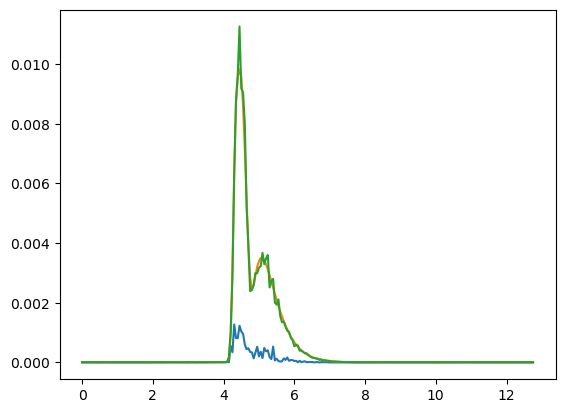

In [18]:
plt.plot(t, result[2]["err"]["delta"] * np.sqrt(m))
plt.plot(t, thz.noiseamp(np.sqrt(result[0]["var"]), result[0]["mu"], ts))
plt.plot(t, np.std(x, axis=0))
plt.show()